# Common

In [1]:
#!pip install tqdm

In [2]:
import json
import time
from subprocess import Popen, PIPE, STDOUT
import math
import numpy as np
import pandas as pd
import hashlib
import requests
import os, sys, subprocess
from tqdm.contrib.concurrent import process_map
from tqdm.notebook import tqdm
tqdm.pandas()
import multiprocessing as mp
import shutil
import urllib.parse
import glob
import os
import sys
from ast import literal_eval
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [3]:
!mkdir -p Temp
!mkdir -p Result

In [4]:
current_path = os.getcwd()

In [5]:
def bracket_row(row):    
    s = row['data']
    index = min(s.find('.'), s.find('('))
    data = row['data']
    row['data'] = data[0:index]
    row['bracket'] = data[index:]
    return row

In [6]:
def adjust(text,n=7):
    text = str(text)    
    return " " * (n - len(text)) + text

In [7]:
def bracket_to_ct(tag, data, bracket, deltaG, negative_deltaG=True):    
    deltaG = deltaG.replace('(','').replace(')','')
    deltaG = float(deltaG)
    if(deltaG > 0 and negative_deltaG ): # negetive?!
        deltaG = -1 * deltaG
    stack = []
    index = np.zeros((len(bracket)), dtype = int)
    values = np.zeros((len(bracket)), dtype = int)
    for i in range(len(bracket)):
        index[i] = i + 1
        if(bracket[i] == '.'):
            values[i] = 0
        elif(bracket[i] == '('):
            stack.append(i)
        elif(bracket[i] == ')'):
            if(len(stack) == 0 ):
                print('structure error!')
            values[stack[-1]] = i + 1
            values[i]  = stack[-1] + 1
            stack.pop()
        else:
            print('structure error!')
    if(len(stack) != 0 ):
        print('structure error!')
    # body    
    ct = f"{adjust(len(data),6)} dG ={adjust(deltaG,10)} {tag}\n"   
    for i in range(len(bracket)):
        ct += f"{adjust(index[i],6)} {data[i]} {adjust(i,6)} {adjust((i+2)%(len(data)+1),6)} {adjust(values[i],6)} {adjust(index[i],7)}\n"
    return ct

In [8]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    tags = []
    data = []
    for l in lines:
        if(l[0]=='>'):
            tags.append(l)        
            data.append(s)
            s = ''
        else:
            s += l    
    data.append(s)
    df = pd.DataFrame(
            {
                'tag': tags,
                'data': data[1:]
            })
    df['tag'] = df['tag'].apply(lambda x: x[1:])    
    return df

In [9]:
def df_to_fasta(df, path):
    lines = []
    df.apply(lambda row: lines.append(f">{row['tag']}\n{row['data']}\n"),axis=1)
    with open(path,'w') as file:
        file.write(''.join(lines))

In [10]:
def reformat(path):
    return path.replace('(','_').replace(')','_').replace('.','').replace(':','_')

In [11]:
def reformatCT(path):
    with open(path, 'r') as file:
        text = file.read()
    text = [l for l in text.split('\n') if len(l) > 0 ] # remove blank lines
    text = '\n'.join(text)
    text = text.replace("\t"," ")
    while("  " in text):
        text = text.replace("  ", " ")
    lines = [l for l in text.split('\n')]
    for i in range(len(lines)):
        if(lines[i][0] == " "):
            lines[i] = lines[i][1:]
        if(lines[i][-1] == " "):
            lines[i] = lines[i][:-1]
    text = '\n'.join(lines)
    return text

In [12]:
def get_ct_data(ct):
    ct = "\n".join(ct.split('\n')[1:])
    df = pd.read_csv(StringIO(ct), sep=" ", header=None)               
    nucleotide = df.iloc[:,1]
    index = df.iloc[:,5]
    values = df.iloc[:,4]
    return [nucleotide, index, values]

In [13]:
def ct2dot_bracket(path):
    [nucleotide, index, values] = get_ct_data(reformatCT(path))
    text = ''.join(nucleotide) + "\n"
    watch = []
    for i, v in zip(index,values):
        if(v == 0):
            text += '.'
        else:
            if( v not in watch):
                text += '('
                watch.append(i)
            if( v in watch):
                text += ')'
    return text

In [14]:
def is_nested(index, values):
    max_value = max(index) + 10 # inf
    for i, v in zip(index, values):
        if(v < max_value and v != 0):
            max_value  = v
        if(i >= max_value):
            max_value = max(index) + 10 # inf
        if(v > max_value):
            return False               
    return True

# CTAnalizer

In [15]:
def get_tag_info(tag):    
    data = tag.split('|')
    chromosome = data[0] 
    sign = data[1]
    start = int(data[2].split('-')[0]) - 1 
    end = int(data[2].split('-')[1])
    hit_start = int(data[3].split('-')[0]) - 1 
    hit_end = int(data[3].split('-')[1])    
    return [chromosome, start, end, hit_start, hit_end, sign]

In [16]:
def get_deltaG(ct):
    ct_head = ct.split('\n')[0]
    if("dG = " in ct_head):    
        dG_patter = "dG = " 
    elif("dG= " in ct_head):    
        dG_patter = "dG= "
    elif("dG=" in ct_head):    
        dG_patter = "dG="
    elif("dG =" in ct_head):    
        dG_patter = "dG ="
    else:
        print('there is no dG')
    return float(ct_head.split(dG_patter)[-1].split(' ')[0])

In [17]:
def get_complementarity_in_hit_region(inc_srange, hit_len):    
    if(sum(inc_srange == 0) == hit_len):
        return ["no" , 0]
    elif(sum(inc_srange != 0) == hit_len):
        return ["fully_connected" , 1]
    else:    
        return ["yes",  round(sum(inc_srange != 0) / hit_len,2)]

In [18]:
def get_hit_self_complementarity(hit_start, hit_end, inc_srange):    
    if(((inc_srange <= hit_start) | (inc_srange > hit_end)).all()):
        return "no"
    return "yes"

In [19]:
def get_istar_min_max(inc_srange, hit_self_complementarity):
    nonzero_data_srange  = inc_srange[inc_srange!=0]
    if(hit_self_complementarity == 'yes'):
        return [np.nan, np.nan]
    return [nonzero_data_srange.min(), nonzero_data_srange.max()]

In [20]:
def get_continuous_pairing(hit_start, hit_end, istar_min, istar_max, hit_self_complementarity):    
    if(hit_self_complementarity == 'yes'):
        return "undifined"
    if(hit_end < istar_max and (hit_start+1) > istar_min):
        return "no"    
    return  "yes"

In [21]:
def get_mir_type(hit_start, hit_end, istar_min, istar_max, continuous_pairing, complementarity_in_hit_region, hit_self_complementarity):        
    if(continuous_pairing == "yes" and complementarity_in_hit_region != "no" and hit_self_complementarity == "no"):
        if( hit_end < istar_min):
            return "5p" 
        if( (hit_start+1) > istar_max):
            return "3p"     
    else:
        if(continuous_pairing == "no" and hit_self_complementarity == "yes"):
            return "discontinuous star strand and hit self complementarity"
        elif(continuous_pairing == "no"):
            return "discontinuous star strand"
        elif(hit_self_complementarity == "yes"):
            return "hit self complementarity"

    if(complementarity_in_hit_region == "no"):
        return "no complementarity in hit region"  
    print(hit_start, hit_end, istar_min, istar_max, continuous_pairing, complementarity_in_hit_region, hit_self_complementarity)

In [22]:
'''
def get_star_start(hit_start, hit_end, values):
    c = 0
    i = hit_end - 3 - c
    while(values[i] == 0 and i >= 0):
        c += 1
        i = hit_end - 3 - c        
    if(values[i] - c < 1):                    
        return [max(values[i] - c,1), "negative value"]
    if(i < hit_start):
        return [values[i] - c, 'less than hit start']
    return [values[i] - c, '']
'''
def get_star_start(hit_start, hit_end, values):        
    a = 0
    i = hit_end - 1
    while(values[i] == 0 and i >= hit_start):
        a += 1
        i = hit_end - 1 - a        
    if((values[i] - a + 2) < 1):                    
        return [max(values[i] - a + 2, 1), "negative value"]
    if(i < hit_start):
        return [values[i] - a + 2, 'less than hit start']
    return [values[i] - a + 2, '']

In [23]:
'''
def get_star_end(hit_start, hit_end, values):
    if(hit_start - 2 >= 0 ):
        a = 0    
    else:
        a = abs(hit_start - 2)
    
    i = hit_start - 2 + a
    while(values[i] == 0 and i <= hit_end):
        a += 1
        i = hit_start - 2 + a
    
    if(i <= hit_end):        
        if((values[i] + a) > len(values)):
            return [len(values), "out of sequance range"]        
        return [values[i] + a, ""]
    return [np.nan, "some error happened"]
'''

def get_star_end(hit_start, hit_end, values):    
    a = 0
    i = hit_start 
    while(values[i] == 0 and i <= hit_end):
        a += 1
        i = hit_start + a
    
    if(i <= hit_end):        
        if((values[i] + a + 2) > len(values)):
            return [len(values), "out of sequance range"]        
        return [values[i] + a + 2, ""]
    return [np.nan, "some error happened"]


In [24]:
def get_num_of_linking_residues(hit_start, hit_end, star_start, star_end, mir_type):
    if(mir_type == '5p'):
        return str(star_start - hit_end - 1)
    elif(mir_type == '3p'):
        return str(hit_start - star_end)    

In [25]:
def get_star_branching(star_start, star_end, star_range, values):
    return not ((values[star_range-1] < star_start) | (values[star_range-1] > star_end)).all()

In [26]:
def getBOI_5p(hit_start, hit_end, values):
    # first calc latest non zero value
    for i in range(hit_end-1, 0, -1):
        if(values[i] != 0):
            last_v = values[i]
            last_i = i
            place = i
            break            
            
    for i in range(place-1, 0, -1):
        v = values[i]
        if(v == 0):
            continue
        if(v < last_v):
            if(last_i <= hit_start and last_i <= hit_end and last_v > hit_start and last_v >= hit_end):                
                return [last_i + 1, last_v]            
        
        if((v - last_v) >= 3):            
            s1 = set(range(last_v+1, v))
            s2 = set([values[ii-1] for ii in range(last_v+1, v)])                        
            if(len(s1.intersection(s2)) > 0):                                                
                if(last_i <= hit_start and last_i < hit_end and last_v > hit_start and last_v >= hit_end): #?????                     
                    return [last_i + 1, last_v]    
        last_v = v            
        last_i = i            
    for i in range(0,hit_start):
        if(values[i] != 0 ):
            if(last_i <= hit_start and last_i <= hit_end and last_v > hit_start and last_v >= hit_end):                    
                return [i + 1, values[i]]          
    return [np.nan, np.nan]    
    
                
def getBOI_3p(hit_start, hit_end, values):
    # first calc latest non zero value
    for i in range(hit_start, len(values)):    
        if(values[i] != 0):
            last_v = values[i]
            last_i = i
            place = i
            break            
            
    for i in range(place + 1, len(values)):
        v = values[i]
        if(v == 0):
            continue
        if(v > last_v):
            if((last_v-1) <= hit_start and (last_v-1) <= hit_end and (last_i+1)  > hit_start and (last_i+1)  >= hit_end):    
                return [last_v, last_i + 1]                                                                                    
        if((last_v - v) >= 3):
            s1 = set(range(v+1, last_v))
            s2 = set([values[ii-1] for ii in range(v+1, last_v)])
            if(len(s1.intersection(s2)) > 0):
                if((last_v-1) <= hit_start and (last_v-1) < hit_end and (last_i+1)  > hit_start and (last_i+1)  >= hit_end):
                    return [last_v, last_i + 1]    
        last_v = v            
        last_i = i            
    for i in range(len(values)-1, hit_end-2, -1):  # changed!        
        if(values[i] != 0 ):
            if((last_v-1) <= hit_start and (last_v-1) <= hit_end and (last_i+1)  > hit_start and (last_i+1)  >= hit_end):                    
                return [values[i], i + 1]    
    return [np.nan, np.nan]
    
    
def get_boi(hit_start, hit_end, values, mir_type):    
    if(mir_type == '5p'):
        return getBOI_5p(hit_start, hit_end, values)
    if(mir_type == '3p'):
        return getBOI_3p(hit_start, hit_end, values)

In [27]:
def get_terminal_structure_range(hit_start, hit_end, istar_min, istar_max, mir_type):
    if(mir_type == '5p'):
        return [i for i in range(hit_end, istar_min-1)]
    if(mir_type == '3p'):
        return [i for i in range(istar_max, hit_start)]
    print("Error in get_terminal_structure_range function")        

In [28]:
def get_number_of_terminal_structure(values, terminal_structure_range):    
    data = values[terminal_structure_range]
    data = data[data != 0].to_numpy()
    if(len(data) == 0):
        return 0           
    counter = 1            
    last = data[0]         
    for i in range(1,len(data)): 
        if(data[i] > last):
            counter += 1
        last = data[i]        
    return counter 

In [29]:
def get_branch_star_end_point(values, terminal_structure_range):        
    data = values[terminal_structure_range]    
    index = np.array(terminal_structure_range)[data != 0]    
    data = data[data != 0].to_numpy()                        
    branch_start_index = []
    branch_end_index = []
    branch_start_index.append(index[0])
    last = data[0]            
    for i in range(1,len(data)): 
        if(data[i] > last):
            branch_end_index.append(index[i-1])
            branch_start_index.append(index[i])
        last = data[i]        
    branch_end_index.append(index[-1])
    #
    branch_start_point = []
    branch_end_point = []
    for i in range(0, len(branch_start_index)):         
        i_s = branch_start_index[i]
        i_e = branch_end_index[i]
        v_s = values[i_s]
        v_e = values[i_e]
        if(v_s > i_s and v_s <= (i_e + 1)):
            branch_start_point.append(i_s + 1)
            branch_end_point.append(v_s)
        elif(v_e > i_s and v_e <= (i_e + 1)):
            branch_start_point.append(v_e)
            branch_end_point.append(i_e + 1)        
    return [branch_start_point, branch_end_point]

In [30]:
def get_branch_apical_loop_size(branch_start_point, branch_end_point, values):        
    branch_apical_loop_start = []
    branch_apical_loop_end = []
    branch_apical_loop_size = []
    for s,e in zip(branch_start_point, branch_end_point):
        data = values[s-1: e]
        index = np.array([i for i in range(s-1, e)])[data != 0]                    
        for i in range(len(index)-1):
            if(values[index[i+1]] == index[i]+1 and values[index[i]] == index[i+1]+1):
                branch_apical_loop_start.append(index[i]+1)
                branch_apical_loop_end.append(index[i+1]+1)
                branch_apical_loop_size.append(index[i+1] - index[i] - 1)                                                
    return [branch_apical_loop_start, branch_apical_loop_end, branch_apical_loop_size]

In [31]:
def get_stem_last_residue(branch_apical_loop_start,branch_apical_loop_end, mir_type):
    out = []
    for i in range(len(branch_apical_loop_start)):
        if(mir_type == '5p'):
            out.append(min(branch_apical_loop_start[i], branch_apical_loop_end[i]))
        if(mir_type == '3p'):
            out.append(max(branch_apical_loop_start[i], branch_apical_loop_end[i]))
    return out

In [32]:
def get_branch_stem_length(branch_start_point, branch_apical_loop_start):
    out = []
    for i in range(len(branch_start_point)):
        out.append(branch_apical_loop_start[i] - branch_start_point[i] + 1)
    return out

In [33]:
def get_primary_stem_end_point(branch_start_point, branch_end_point, stem_last_residue, hit_start, hit_end, istar_min, istar_max, values, number_of_terminal_structure, mir_type):    
    if(number_of_terminal_structure == 1):
        return stem_last_residue[0]
    if(mir_type == '5p'):
        if(number_of_terminal_structure == 0):                            
            for i in range(hit_end-1, hit_start-1,-1):
                if(values[i] != 0):
                    return i + 1
        else:
            a = -1                        
            for i in range(branch_start_point[0]-2, hit_end-1, -1):                
                if(values[i] != 0):
                    a = i + 1
                    break            
            b = -1            
            for i in range(branch_end_point[-1], istar_min - 1):
                if(values[i] != 0):
                    b = values[i]
                    break                   
            if(a == -1 or b == -1):
                return np.nan
            return min(a,b)
            
    if(mir_type == '3p'):
        if(number_of_terminal_structure == 0):                
            for i in range(hit_start, hit_end):
                if(values[i] != 0):
                    return i + 1 
        else:
            a = -1
            for i in range(branch_end_point[-1], hit_start):
                if(values[i] != 0):
                    a = i + 1
                    break            
            
            b = -1            
            for i in range(branch_start_point[0]-2, istar_max-1, -1):                
                if(values[i] != 0):
                    b = values[i]
                    break                    
            
            if(a == -1 or b == -1):
                return np.nan
            return max(a,b)

In [34]:
def get_primary_stem_length(primary_stem_end_point, branch_start_point, branch_end_point, stem_last_residue, hit_start, hit_end, values, number_of_terminal_structure ,mir_type):    
    if(number_of_terminal_structure == 0):
        return 0
    if(mir_type == '5p'):
        if(number_of_terminal_structure == 1):                
            return stem_last_residue[0] - branch_start_point[0] + 1
        else:                        
            return primary_stem_end_point - hit_end
            
    if(mir_type == '3p'):
        if(number_of_terminal_structure == 1):                
            return branch_end_point[0] - stem_last_residue[0] + 1
        else:                        
            return (hit_start+1) - primary_stem_end_point

In [35]:
def get_domain(primary_stem_end_point, boi_start, boi_end, stem_last_residue, hit_start, hit_end, mir_type):    
    if(mir_type == '5p'):        
        return range(boi_start-1, primary_stem_end_point)                                        
    if(mir_type == '3p'):        
        return range(primary_stem_end_point-1, boi_end)

In [36]:
def get_domain_star(primary_stem_end_point_star, boi_start, boi_end, stem_last_residue, hit_start, hit_end, mir_type):    
    if(mir_type == '5p'):        
        return range(primary_stem_end_point_star - 1, boi_end)                                        
    if(mir_type == '3p'):        
        return range(boi_start-1 , primary_stem_end_point_star)

In [37]:
def get_interfering_structures(domain, values):
    [c, d] = [min(domain[0], domain[-1]) + 1, max(domain[0], domain[-1]) + 1]            
    v = values[c-1:d]        
    return not ((v < c) | (v > d)).all()

In [38]:
def getLocation(start, end, hit_start, hit_end, mir_type):            
    def _location(point): # base location              
        if(mir_type == "5p"):                        
            if(point < (hit_start+1)):
                return ["loop distal", (hit_start+1) - point]
            if(point <= hit_end):
                return ["hit region", point - (hit_start+1) + 1]
            return ["loop proximal" , point - hit_end]
        
        if(mir_type == "3p"):    
            if(point > hit_end):
                return ["loop distal" , point - hit_end]
            if(point >= (hit_start+1)):
                return ["hit region", point - (hit_start+1) + 1]
            return ["loop proximal", (hit_start+1) - point]                                        
            
    [type1, loc1] = _location(start)
    [type2, loc2] = _location(end)    
    if(type1 == type2):                
        return [type1, min(loc1, loc2), max(loc1, loc2)]
    
    if((type1 == "loop distal" and type2 == "hit region") or
       (type2 == "loop distal" and type1 == "hit region")):                
        return ["distal border line", loc1, loc2]
        
    if((type1 == "loop proximal" and type2 == "hit region") or
       (type2 == "loop proximal" and type1 == "hit region")):        
        return ["proximal border line", loc1, loc2]
    
    raise exception("loop proximal and loop distal")

In [39]:
def get_mismatch(domain, values, MCMA, hit_start, hit_end, mir_type): #MCMA: maximum consecutive mismatch allowance    
    size = []
    location_type = []
    location_start = []
    location_end = []
    if(values[domain[0]] == 0 or values[domain[-1]] == 0):
        raise Exception("Domain start or end = 0")        
        return "Domain start or end = 0"
    mismatch_counter = 0 
    zero_counter = 0
    last = values[domain[0]]    
    lastI = domain[0]
    for d in domain[1:]:
        if(values[d] == 0):
            zero_counter += 1
        else:            
            current = values[d]
            if(current > last):
                return ["Increment series error", None, None, None, None]
            elif(current < last and zero_counter > 0):                
                if(last - current - 1 == zero_counter and zero_counter <= MCMA):
                    mismatch_counter += 1
                    size.append(zero_counter)                    
                    [loc_type, loc_start, loc_end ] = getLocation(lastI+2, d, hit_start, hit_end, mir_type)
                    location_type.append(loc_type)
                    location_start.append(loc_start)
                    location_end.append(loc_end)                    
                zero_counter = 0                                    
            last = current
            lastI = d
    if(mir_type == "3p"):
        size = size[::-1]
        location_type = location_type[::-1]
        location_start = location_start[::-1]
        location_end = location_end[::-1]
    return [mismatch_counter, size, location_type, location_start, location_end]

In [40]:
def get_bulge(domain, values, hit_start, hit_end, mir_type): 
    size = []  
    bulge_type = []
    location_type = []
    location_start = []
    location_end = []
    zero_counter = 0
    last = values[domain[0]]  
    lastI = domain[0]
    for d in domain[1:]:
        if(values[d] == 0):
            zero_counter += 1
        else:
            current = values[d]
            if(current > last):
                return ["Increment series error", None, None, None, None,None]
            
            if(last - current == 1 and zero_counter > 0):                
                size.append(zero_counter)                            
                [loc_type, loc_start, loc_end ] = getLocation(lastI+1, d+1, hit_start, hit_end, mir_type)
                bulge_type.append("zero")                                
                location_start.append(loc_start)
                location_end.append(loc_end)           
                [loc_type,_,_ ] = getLocation(lastI+2, d, hit_start, hit_end, mir_type)
                location_type.append(loc_type)
                
            if(last - current > 1 and zero_counter == 0):                
                size.append(last - current - 1)                
                [loc_type, loc_start, loc_end ] = getLocation(lastI+2, d, hit_start, hit_end, mir_type)
                if(loc_type == "distal border line"):
                    loc_type = "loop distal"
                if(loc_type == "proximal border line"):
                    loc_type = "loop proximal"
                bulge_type.append("jump")
                location_type.append(loc_type)
                location_start.append(loc_start)
                location_end.append(loc_end)                    
                                            
            zero_counter = 0                                                    
            last = current
            lastI = d
    if(mir_type == "3p"):
        size = size[::-1]
        bulge_type = bulge_type[::-1]
        location_type = location_type[::-1]
        location_start = location_start[::-1]
        location_end = location_end[::-1]
    return [len(size), size, location_type, location_start, location_end, bulge_type]

In [41]:
def get_internal_loop(domain, values, MCMA, hit_start, hit_end, mir_type): #MCMA: maximum consecutive mismatch allowance
    size_HSBL = []  # number of         
    size_SSBL = []     
    location_type = []
    location_start = []
    location_end = []
    zero_counter = 0
    last = values[domain[0]]    
    lastI = domain[0]
    for d in domain[1:]:
        if(values[d] == 0):
            zero_counter += 1
        else:
            current = values[d]            
            if(current > last):
                return ["Increment series error", None, None, None, None, None]        
            if(current < last and zero_counter > 0):                
                jump = last - current - 1
                if(jump == 0):
                    zero_counter = 0                                    
                elif(jump != zero_counter):                                        
                    size_HSBL.append(zero_counter)
                    size_SSBL.append(jump)
                    [loc_type, loc_start, loc_end ] = getLocation(lastI+2, d, hit_start, hit_end, mir_type)
                    location_type.append(loc_type)
                    location_start.append(loc_start)
                    location_end.append(loc_end)                    
                elif(zero_counter > MCMA):
                    size_HSBL.append(zero_counter)
                    size_SSBL.append(jump)
                    [loc_type, loc_start, loc_end ] = getLocation(lastI+2, d, hit_start, hit_end, mir_type)
                    location_type.append(loc_type)
                    location_start.append(loc_start)
                    location_end.append(loc_end)                    
                    
            zero_counter = 0                                    
            last = current
            lastI = d
    if(mir_type == "3p"):        
        size_SSBL = size_SSBL[::-1]
        size_HSBL = size_HSBL[::-1]
        location_type = location_type[::-1]
        location_start = location_start[::-1]
        location_end = location_end[::-1]
    return [len(size_HSBL), size_HSBL, size_SSBL, location_type, location_start, location_end]

In [42]:
def get_distance_info(inp_type, inp_bord_type, mis_loc_type, mismatch_size, mis_start, bulge_size, bulge_loc_type, bulge_start,bulge_end, bulge_type,internal_loop,size_HSBL,size_SSBL,intr_loc_type,intr_start,intr_end, mir_type):
    counter = 0 
    data = []
    # mismatch
    if(mis_loc_type != None):
        for i in range(0, len(mis_loc_type)):
            if(mis_loc_type[i] == inp_type):
                data.append({'start':mis_start[i],
                             'size': mismatch_size[i],
                             'type':"mismatch"})
    # bulge
    if(bulge_loc_type != None):
        for i in range(0, len(bulge_loc_type)):
            if(bulge_loc_type[i] == inp_type):
                data.append({'start':bulge_start[i],
                              'size': bulge_size[i],
                              'end': bulge_end[i],
                              'bulge_type': bulge_type[i],
                              'type':"bulge"})
            if(bulge_loc_type[i] == inp_bord_type and
                bulge_type[i] == "zero"):
                if(inp_bord_type == "distal border line"):
                    if(mir_type == "5p"):
                        counter = bulge_start[i] - 1 
                    if(mir_type == "3p"):
                        counter = bulge_end[i] - 1 
                if(inp_bord_type == "proximal border line"):
                    if(mir_type == "5p"):
                        counter = bulge_end[i] - 1 
                    if(mir_type == "3p"):
                        counter = bulge_start[i] - 1 
    # loop
    if(intr_loc_type != None):
        for i in range(0, len(intr_loc_type)):
            if(intr_loc_type[i] == inp_type):
                data.append({'start': intr_start[i],
                         'HSBL' : size_HSBL[i],
                         'SSBL' : size_SSBL[i],
                         'end'  : intr_end[i],
                         'type' : "loop"})
            if(intr_loc_type[i] == inp_bord_type and
               size_HSBL[i] > size_SSBL[i] and
               intr_end[i] > size_SSBL[i]):
                counter = intr_end[i] - size_SSBL[i]    
    if(len(data) == 0):
        return [[], [], counter]
    data.sort(key=lambda x: x['start'], reverse=False)
    #
    output = []
    outputhr = []
    for d in data:
        # todo
        dist = d['start'] - counter - 1
        if(d['type']== "mismatch"):
            output.append({'type':"mismatch",
                           'dist': dist,
                           'size': d['size']})
            outputhr.append(f"mismatch=dist:{dist}, size:{d['size']}")
        if(d['type']== "bulge"):
            dist = d['start'] - counter
            output.append({'type':"bulge",
                           'dist': dist,
                           'size': d['size']})
            outputhr.append(f"bulge=dist:{dist}, size:{d['size']}")
            if(d['bulge_type'] == "zero"):
                counter +=  d['size']
        if(d['type']== "loop"):
            dist = d['start'] - counter - 1
            _size = str(d['HSBL'])+ " + " + str(d['SSBL'])
            output.append({'type':"loop",
                           'dist': dist,
                           'size': _size})
            outputhr.append(f"loop=dist:{dist}, size:{_size}")
            if(d['HSBL'] > d['SSBL']):
                counter += d['HSBL'] - d['SSBL']
    return [output,outputhr, counter]

In [43]:
def closestto(data, datahr,number=15):
    for d in data:
        if(d['type'] == "mismatch"):
            data.remove(d)
    dist = []
    if(len(data)==0):
        return ""
    for d in data:
        dist.append(abs(d['dist'] - number))
    min_dist = min(dist)
    out = []
    for i in range(0,len(dist)):
        if(dist[i] == min_dist):
            out.append(data[i])
            
    output = []
    for o in out:
        output.append(f"{o['type']}=dist:{o['dist']}, size:{o['size']}")                
    return output

In [44]:
def get_gc_content(seq):
    freq = pd.Series([c.lower() for c in seq]).value_counts()
    for i in ['c','g', 's']:
        if i not in freq:
            freq[i] = 0    
    return round((freq['c'] + freq['g'] + freq['s']) / len(seq),2) * 100

In [45]:
def get_boi_dist(boi_start, boi_end, hit_start, hit_end, mir_type, counter):    
    if(mir_type == '5p'):        
        return (hit_start + 1) - boi_start  - counter 
    if(mir_type == '3p'):
        return  boi_end - hit_end - counter 

def get_psep_dist(psep, mir_type, hit_start, hit_end, counter):
    if(mir_type == '5p'):
        return abs(psep - hit_end) - counter
    if(mir_type == '3p'):
        return  abs((hit_start + 1) - psep)  - counter

In [46]:
def get_junction_distance(data, dist, thresh_bulge, thresh_loop):
    distance = []
    for d in data:
        if(d['type'] == 'loop'):
            size = eval(d['size'])
            if(size >= thresh_loop):                
                distance.append(d['dist'])
        if(d['type'] == 'bulge'):
            if(d['size'] >= thresh_bulge):
                distance.append(d['dist'])
    distance.append(dist)
    return min(distance)

In [47]:
def get_ct2dot_bracket(nucleotide, index, values):
    text = ''.join(nucleotide) + "%5Cn"
    watch = []
    for i, v in zip(index,values):
        if(v == 0):
            text += '.'
        else:
            if( v not in watch):
                text += '('
                watch.append(i)
            if( v in watch):
                text += ')'
    return text

In [48]:
def get_visualization_link(dotbracket, color):
    base ="http://nibiru.tbi.univie.ac.at/forna/forna.html"        
    return f"{base}?id=fasta&file=%3Eheader%5Cn{dotbracket}&colors=%3Eheader%5Cnrange%5C%3Dwhite:blue{color}"

In [49]:
def visualization(nucleotide, index, values, hit_start, hit_end, boi_start, boi_end, star_start_real, start_end_real ):    
    dotbracket = get_ct2dot_bracket(nucleotide, index, values)
    colors = ""
    for i in range(0,len(index)):
        v = i + 1 
        if( (hit_start+1) <= v and v  <= hit_end):
            colors += "%5Cn1.2"
            continue
        if(star_start_real != None and start_end_real != None):
            if( star_start_real <= v and v <= start_end_real):
                colors += "%5Cn0.8"
                continue
        if(boi_start != None and boi_end != None):
            if( boi_start <= v and v <= boi_end):
                colors += "%5Cn0.2"
                continue        
        colors += "%5Cn0"
    path = get_visualization_link(dotbracket, colors)    
    return path
    #return f'=HYPERLINK("{path}","url")'

In [50]:
def get_trim_data(nucleotide, index, values, start, end):
    _n = nucleotide.copy()[start-1:end].reset_index(drop=True)
    _i = (index.copy()[start-1:end] - (start - 1)).reset_index(drop=True)
    _v = values.copy()[start-1:end].apply(lambda x: 0 if x==0 else  max(x - (start - 1),0)).reset_index(drop=True)   
    return [_n, _i, _v]

In [51]:
def get_precursor_seq(hit_start, hit_end,istar_min, istar_max, star_start_real, star_end_real, mir_type):
    if(mir_type == "3p"):
        return [star_start_real, hit_end, [hit_end-1, hit_end]]
    if(mir_type == "5p"):
        return [hit_start+1, star_end_real,[i+1 for i in range(istar_max, star_end_real)]]

In [52]:
def get_AMFE(dg, nuc):    
    return abs((dg / len(nuc)) * 100)

def get_MFEI(dg, gc, nuc):    
    return abs(((dg / len(nuc)) * 100) / ( gc))

In [53]:
def get_dg_by_vienna(dotbracket):
    dotbracket = dotbracket.replace("%5Cn", "\n")        
    process = Popen(["RNAeval", "-T", "22"], stdout=PIPE, stdin=PIPE, stderr=STDOUT)     
    (output, err) = process.communicate(input=bytes(dotbracket, 'ascii'))       
    exit_code = process.wait()           
    if(err):
        dg = None        
    else:
        dg = float(output[(len(dotbracket)+2):-2])   
    return dg

In [54]:
def get_dg_by_unafold(nucleotide, index, values):
    st = time.time()
    ct_str = f'{len(nucleotide)}\n'
    for i in range(0, len(nucleotide)):
        ct_str += f'     {i+1} {nucleotide[i]}      {i}      {i+2}      {values[i]}       {index[i]}\n'                
    process = Popen(["ct-energy", "-t", "22"], stdout=PIPE, stdin=PIPE, stderr=STDOUT)    
    (output, err) = process.communicate(input=bytes(ct_str, 'ascii'))        
    exit_code = process.wait()             
    if(err):
        dg = None        
    else:
        dg = float(output)     
    return dg

In [55]:
server_url = "http://jupyter.sysmanager.ir/tree/plant_microRNA_prediction"
#MCMA: maximum consecutive mismatch allowance
def get_row(tag, path, extra, acceptable_terminal_structures = 5, MCMA=2, effective_bulge_size_in_Hit_vicinity_regions=4,            
effective_internal_loop_size_in_Hit_vicinity_regions=5, energy_calc_method="UNAFold"):            
    result = {}    
    ct = reformatCT(path)    
    result['seq name'] = tag
    fold_number = "1" #path[-20:].split('SEQ_')[1].split('.ct')[0]    
    result['ct name'] = "Fold " + fold_number.zfill(2)
    #print(result['ct name'] )    
    result['ct'] = f'=HYPERLINK("{server_url + path[1:]}","ct")'
    result['pdf'] = f'=HYPERLINK("{server_url + path[1:-3] + ".pdf"}","pdf")'         
    [chromosome, start, end, hit_start, hit_end, sign] = get_tag_info(tag)        
    result['hit start'] = hit_start + 1
    result['hit end'] =  hit_end
    result['sign'] = sign
    result['chromosome'] = chromosome 
    result['hit position on chromosome'] = f'{start + hit_start-1}-{start + hit_end}' 
    dg = get_deltaG(ct)
    result['delta G'] = dg
    [nucleotide, index, values] = get_ct_data(ct)
    result['full seq'] = ''.join(nucleotide)    
    hit_seq = ''.join(nucleotide[hit_start:hit_end])    
    result['full seq visualization'] = visualization(nucleotide, index, values, hit_start, hit_end, None, None,None, None)
    result['hit seq'] = hit_seq
    hit_range = index[hit_start:hit_end]
    hit_len = len(hit_range)
    result['hit len'] = hit_len
    flanking_gc_content = get_gc_content(nucleotide)
    result['flanking GC content'] = flanking_gc_content
    result['flanking MFEI'] = get_MFEI(dg, flanking_gc_content, nucleotide)
    result['hit GC content'] =  get_gc_content(hit_seq)
    inc_srange = values[hit_start:hit_end] # Incomplete_Star_range    
    [complementarity_in_hit_region, complementarity_in_hit_region_percentage] = get_complementarity_in_hit_region(inc_srange, hit_len)    
    result['complementarity in hit region'] = complementarity_in_hit_region 
    result['hit complementarity percentage']  = complementarity_in_hit_region_percentage
    if(complementarity_in_hit_region == "no"):        
        result['message'] = "no complementarity in hit region"        
        return pd.Series(result) 
    
    hit_self_complementarity = get_hit_self_complementarity(hit_start, hit_end, inc_srange)    
    result['hit self complementarity'] = hit_self_complementarity       
    if(hit_self_complementarity == "yes"):        
        result['message'] = "hit self complementarity"
        return pd.Series(result)     
    if(hit_start - extra < 0 or (len(values) - hit_end) < extra):        
        result['message'] = "Not enough flanking for hit region"                
        return pd.Series(result) 
    
    [flanking_istar_min, flanking_istar_max] = get_istar_min_max(values[(hit_start-extra):(hit_end+extra)], hit_self_complementarity)  
    #result['flanking istar min']  = flanking_istar_min
    #result['flanking istar max']  = flanking_istar_max    
    
    continuous_pairing = get_continuous_pairing(hit_start, hit_end, flanking_istar_min, flanking_istar_max, hit_self_complementarity)
    result['continuous pairing'] = continuous_pairing    
    if(continuous_pairing == "no"):
        result['message'] = "discontinuous star strand"
        return pd.Series(result) 
    
    [istar_min, istar_max] = get_istar_min_max(inc_srange, hit_self_complementarity)  
    result['istar min']  = istar_min
    result['istar max']  = istar_max
    
    mir_type = get_mir_type(hit_start, hit_end, istar_min, istar_max, continuous_pairing, complementarity_in_hit_region, hit_self_complementarity)
    result['mir type'] = mir_type    
    if(mir_type not in ['3p', '5p']):        
        result['message'] = mir_type
        return pd.Series(result) 
    try: 
        [star_start, star_start_msg] = get_star_start(hit_start, hit_end, values)
        [star_end, star_end_msg] = get_star_end(hit_start, hit_end, values)
        result['star start'] = star_start 
        result['star start msg'] = star_start_msg     
        result['star end'] = star_end    
        result['star end msg'] =  star_end_msg
    except:
        result['message'] = 'Error in calculation of star start and end'        
        return pd.Series(result) 
    
    star_start_real = star_start
    star_end_real = star_end
    star_start = istar_min ############################################
    star_end = istar_max   ############################################
    #set1 = set(range(star_start-1 , star_end))
    set1 = set(range(star_start-2 , star_end+1)) ######################
    set2 = set(range(hit_start, hit_end))            
    if(len(set1.intersection(set2)) > 0):        
        result['message'] = 'overlap between miRNA and miRNA*'        
        return pd.Series(result) 
    
    star_range = index[star_start - 1:star_end]
    star_seq = ''.join(nucleotide[star_start - 1:star_end])
    result['star seq'] = star_seq
    num_of_linking_residues = get_num_of_linking_residues(hit_start, hit_end, star_start_real, star_end_real, mir_type)
    result['num of linking residues'] = num_of_linking_residues
    #print(result)
    star_branching = get_star_branching(star_start, star_end, star_range, values)
    #star_branching = get_star_branching(istar_min, istar_max, inc_srange, values)
    result['star branching'] = "yes" if star_branching else "no"    
    [boi_start, boi_end] = get_boi(hit_start, hit_end, values, mir_type)                    
    if(math.isnan(boi_start) or math.isnan(boi_end)):        
        result['message'] = 'unfit BOI structure'
        return pd.Series(result)    
    boi_seq = ''.join(nucleotide[boi_start-1: boi_end].tolist())
    result['boi start'] = boi_start
    result['boi end'] =  boi_end
    result['boi seq'] =  boi_seq    
    result['boi name'] =  f'{chromosome}|{sign}|{start + boi_start}-{start + boi_end}|{hit_start - boi_start + 2}-{hit_end - boi_start + 1}'
    boi_gc = get_gc_content(boi_seq)
    result['boi GC content'] =  boi_gc
    result['full seq visualization'] = visualization(nucleotide, index, values, hit_start, hit_end, boi_start,  boi_end, star_start_real, star_end_real)
    terminal_structure_range = get_terminal_structure_range(hit_start, hit_end, istar_min, istar_max, mir_type)
    [_n, _i, _v] = get_trim_data(nucleotide, index, values, boi_start, boi_end)
    boi_dotbracket = get_ct2dot_bracket(_n, _i, _v)    
    result['boi dotbracket'] = boi_dotbracket.split("%5Cn")[1]
    if(energy_calc_method == "Vienna" or energy_calc_method =="UNAFold"):
        if(energy_calc_method == "Vienna"):
            boi_dg = get_dg_by_vienna(boi_dotbracket)
            result['boi delta G'] = boi_dg
        if(energy_calc_method =="UNAFold"):
            boi_dg = get_dg_by_unafold(_n, _i, _v)
            result['boi delta G'] = boi_dg
        result['boi AMFE'] = get_AMFE(boi_dg, boi_seq)
        result['boi MFEI'] = get_MFEI(boi_dg, boi_gc, boi_seq)
        result['boi visualization'] = visualization(_n, _i, _v, hit_start - (boi_start - 1), hit_end - (boi_start - 1), 1,  boi_end - (boi_start - 1), star_start_real- (boi_start - 1), star_end_real- (boi_start - 1))
    [s, e, zero] = get_precursor_seq(hit_start, hit_end,istar_min, istar_max, star_start_real, star_end_real, mir_type)    
    [_n, _i, _v] = get_trim_data(nucleotide, index, values, s, e)      
    _v[_v > (e - s + 1)] = 0    
    precursor_dotbracket = get_ct2dot_bracket(_n, _i, _v)    
    precursor_gc = get_gc_content("".join(_n))
    result['precursor gc content'] = precursor_gc
    result['precursor dotbracket'] = precursor_dotbracket.split("%5Cn")[1]
    if(energy_calc_method == "Vienna" or energy_calc_method =="UNAFold"):        
        if(energy_calc_method == "Vienna"):
            precursor_dg = get_dg_by_vienna(precursor_dotbracket)
            result['precursor delta G'] = precursor_dg
        if(energy_calc_method == "UNAFold"):
            precursor_dg = get_dg_by_unafold(_n, _i, _v)
            result['precursor delta G'] = precursor_dg
        if(precursor_dg != None or True):
            result['precursor AMFE'] = get_AMFE(precursor_dg, _n)
            result['precursor MFEI'] = get_MFEI(precursor_dg, precursor_gc, _n)
        else:
            result['precursor AMFE'] = ""
            result['precursor MFEI'] = ""            
    precursor_array = [hit_start+1,hit_end, star_start_real, star_end_real]
    precursor_start = min(precursor_array)
    precursor_end = max(precursor_array)
    result['precursor name'] =  f'{chromosome}|{sign}|{start + precursor_start}-{start + precursor_end}|{hit_start - precursor_start + 2}-{hit_end - precursor_start + 1}'
    result['precursor seq'] = ''.join(_n)
    result['precursor seq visualization'] = visualization(_n, _i, _v, hit_start - (s - 1), hit_end - (s - 1), 1,  e - (s - 1), star_start_real- (s - 1), star_end_real- (s - 1))
    result['terminal structure range'] = [i+1 for i in [terminal_structure_range[0], terminal_structure_range[-1]]]                            
    if(len(terminal_structure_range) == 0):        
        result['number of terminal structures'] = "no residues between miR and miR*"         
    else:                
        number_of_terminal_structure = get_number_of_terminal_structure(values, terminal_structure_range)        
        if(number_of_terminal_structure == 0):
            result['number of terminal structures'] = 0                    
            #[branch_start_point, branch_end_point] = [[terminal_structure_range[0]+1], [terminal_structure_range[-1]+1]]
            [branch_start_point, branch_end_point] = [[], []]   
            stem_last_residue = []
        elif(number_of_terminal_structure == 1):
            result['number of terminal structures'] = 1        
            [branch_start_point, branch_end_point] = [[terminal_structure_range[0]+1], [terminal_structure_range[-1]+1]]            
            stem_last_residue = []
        else:
            result['number of terminal structures'] = number_of_terminal_structure
            [branch_start_point, branch_end_point]  = get_branch_star_end_point(values, terminal_structure_range)         
        if(number_of_terminal_structure != 0):
            #[branch_apical_loop_start, branch_apical_loop_end, branch_apical_loop_size] = [[branch_start_point[0]], [branch_end_point[0]], [abs(branch_end_point[0] - branch_start_point[0]) + 1]]                    
            [branch_apical_loop_start, branch_apical_loop_end, branch_apical_loop_size] = get_branch_apical_loop_size(branch_start_point, branch_end_point, values)
            stem_last_residue = get_stem_last_residue(branch_apical_loop_start,branch_apical_loop_end, mir_type)
            branch_stem_length = get_branch_stem_length(branch_start_point, branch_apical_loop_start)                        
        for i in range(acceptable_terminal_structures):
            if(i < len(branch_start_point)):
                result[f'branch#{i + 1} start point'] = branch_start_point[i]
                result[f'branch#{i + 1} end point'] = branch_end_point[i]
                result[f'branch#{i + 1} total length'] = abs(branch_end_point[i] - branch_start_point[i]) + 1                                                
                result[f'branch#{i + 1} apical loop start'] = branch_apical_loop_start[i]
                result[f'branch#{i + 1} apical loop end'] = branch_apical_loop_end[i]
                result[f'branch#{i + 1} apical loop size'] = branch_apical_loop_size[i]                    
                if(number_of_terminal_structure == 1):
                    result[f'branch#{i + 1} stem last residue'] = stem_last_residue[i]
                else:
                    result[f'branch#{i + 1} stem last residue'] = ""
                result[f'branch#{i + 1} stem length'] = branch_stem_length[i]                
            else:
                result[f'branch#{i + 1} start point'] = ""
                result[f'branch#{i + 1} end point'] = ""            
                result[f'branch#{i + 1} total length'] = ""
                result[f'branch#{i + 1} apical loop start'] = ""
                result[f'branch#{i + 1} apical loop end'] = ""
                result[f'branch#{i + 1} apical loop size'] = ""
                result[f'branch#{i + 1} stem last residue'] = ""
                result[f'branch#{i + 1} stem length']  = ""           
        
        
        primary_stem_end_point = get_primary_stem_end_point(branch_start_point, branch_end_point, stem_last_residue, hit_start, hit_end, istar_min, istar_max, values, number_of_terminal_structure, mir_type)
        if(not np.isnan(primary_stem_end_point)):
            primary_stem_end_point_star = values[primary_stem_end_point-1]
            result['psep'] = primary_stem_end_point
            result['psep*'] = primary_stem_end_point_star
            if(number_of_terminal_structure == 0):
                result[f'branch#{1} apical loop start'] = min(primary_stem_end_point, primary_stem_end_point_star)
                result[f'branch#{1} apical loop end'] = max(primary_stem_end_point, primary_stem_end_point_star)
                result[f'branch#{1} apical loop size'] = abs(primary_stem_end_point - primary_stem_end_point_star) - 1 
                result[f'branch#{1} stem length']  = 0       
            primary_stem_length = get_primary_stem_length(primary_stem_end_point, branch_start_point, branch_end_point, stem_last_residue, hit_start, hit_end, values, number_of_terminal_structure, mir_type)
            result['primary stem length'] = primary_stem_length                            
            
            domain = get_domain(primary_stem_end_point, boi_start, boi_end, stem_last_residue, hit_start, hit_end, mir_type)
            result['domain'] = [domain[0]+1, domain[-1]+1]
            domain_star = get_domain_star(primary_stem_end_point_star, boi_start, boi_end, stem_last_residue, hit_start, hit_end, mir_type)
            result['domain*'] = [domain_star[0] + 1, domain_star[-1] + 1]
            interfering_structures_domain = get_interfering_structures(domain, values)
            result['domain interfering structures'] = "yes" if interfering_structures_domain else "no"
            
            interfering_structures_domain_star = get_interfering_structures(domain_star, values)
            result['domain* interfering structures'] = "yes" if interfering_structures_domain_star else "no"
                        
            [mismatch, mismatch_size, mis_loc_type, mis_start, mis_end] = get_mismatch(domain, values,MCMA, hit_start, hit_end, mir_type)            
            result['mismatch'] = mismatch
            result['mismatch size'] = mismatch_size
            result['mismatch type'] = mis_loc_type
            result['mismatch start'] = mis_start
            result['mismatch end'] = mis_end
            [bulge, bulge_size, bulge_loc_type, bulge_start, bulge_end,bulge_type] = get_bulge(domain, values, hit_start, hit_end, mir_type)
            result['bulge'] = bulge
            result['bulge size'] = bulge_size
            result['bulge type'] = bulge_loc_type
            result['bulge start'] = bulge_start
            result['bulge end'] = bulge_end
            [internal_loop, size_HSBL, size_SSBL, intr_loc_type, intr_start, intr_end] = get_internal_loop(domain, values, MCMA, hit_start, hit_end, mir_type)
            result['internal loop'] = internal_loop
            result['internal loop HSBL'] = size_HSBL
            result['internal loop SSBL'] = size_SSBL
            if(size_SSBL != None):
                result['internal loop total size'] = [size_SSBL[i] + size_HSBL[i] for i in range(len(size_SSBL))]
            else:
                result['internal loop total size'] = '-'
            result['internal type'] = intr_loc_type
            result['internal start'] = intr_start
            result['internal end'] = intr_end
            [proximal, proximal_hr, proximal_counter] = get_distance_info("loop proximal","proximal border line", mis_loc_type,mismatch_size, mis_start, bulge_size, bulge_loc_type, bulge_start,bulge_end, bulge_type,internal_loop,size_HSBL,size_SSBL,intr_loc_type,intr_start,intr_end,mir_type)
            result['proximal distance'] = proximal_hr
            [distal, distal_hr, distal_counter] = get_distance_info("loop distal","distal border line", mis_loc_type,mismatch_size, mis_start, bulge_size, bulge_loc_type, bulge_start,bulge_end, bulge_type,internal_loop,size_HSBL,size_SSBL,intr_loc_type,intr_start,intr_end, mir_type)
            result['distal distance'] = distal_hr
            boi_dist = get_boi_dist(boi_start, boi_end, hit_start, hit_end, mir_type, distal_counter)
            result['base structure corrected length'] = boi_dist
            psep_dist = get_psep_dist(primary_stem_end_point, mir_type, hit_start, hit_end, proximal_counter)
            result['primary stem corrected length'] = psep_dist  
            result['proximal closest to 15'] = closestto(proximal,15) 
            result['proximal closest to 17'] = closestto(proximal,17) 
            result['proximal closest to 21'] = closestto(proximal,21) 
            result['proximal closest to 36'] = closestto(proximal,36)
            result['distal closest to 15'] = closestto(distal,15)
            result['distal closest to 17'] = closestto(distal,17)
            result['distal closest to 21'] = closestto(distal,21)
            result['distal closest to 36'] = closestto(distal,36)
            result['Loop distal junction distance'] = get_junction_distance(distal, boi_dist, effective_bulge_size_in_Hit_vicinity_regions, effective_internal_loop_size_in_Hit_vicinity_regions)            
            result['Loop proximal junction distance'] = get_junction_distance(proximal, psep_dist, effective_bulge_size_in_Hit_vicinity_regions, effective_internal_loop_size_in_Hit_vicinity_regions)            
        else:
            result['message'] = "immediate branching"                        
    return pd.Series(result)

In [56]:
def run(tag, path, extra):        
    return get_row(tag, path, extra)
    try:
        return get_row(tag, path,extra)
    except Exception as e:
        print(str(e), tag)        
        return pd.Series()        

# Apply on current data

In [57]:
base = "./CT_high_viridi"
cts = glob.glob(f'{base}/*.ct')        

In [58]:
def get_df_by_path(path , extra=0):           
    tag = path[(len("./CT_high_viridi/")):-3]    
    return run(tag, path, extra)

In [59]:
max_workers = mp.cpu_count() - 4

dfs = []
for row in process_map(get_df_by_path , cts, tqdm_class=tqdm, max_workers=max_workers, chunksize=5):
    dfs.append(row)
result = pd.DataFrame(dfs)
result = result.replace(np.nan, '-').replace('', '-')            

  0%|          | 0/275 [00:00<?, ?it/s]

In [60]:
def get_max_in_region(row, type_str, size_str, region):
    out = 0
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == region:
            if row[size_str][i] > out:
                out = row[size_str][i]
    return out

def get_number_in_region(row, type_str, size_str, region):
    counter = 0
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == region:
            counter += 1            
    return counter

def get_sum_in_region(row, type_str, size_str, region):
    out = 0
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == region:
            out += row[size_str][i]            
    return out

for region in ["loop distal", "hit region", "distal border line", "loop proximal", "proximal border line"]:
    result[f'max mismatch in {region}'] = result.apply(lambda row: get_max_in_region(row, "mismatch type", "mismatch size", region), axis=1)
    result[f'number mismatch in {region}'] = result.apply(lambda row: get_number_in_region(row, "mismatch type", "mismatch size", region), axis=1)
    result[f'sum mismatch in {region}'] = result.apply(lambda row: get_sum_in_region(row, "mismatch type", "mismatch size", region), axis=1)    
    result[f'max bulge in {region}'] = result.apply(lambda row: get_max_in_region(row, "bulge type", "bulge size", region), axis=1)
    result[f'number bulge in {region}'] = result.apply(lambda row: get_number_in_region(row, "bulge type", "bulge size", region), axis=1)
    result[f'sum bulge in {region}'] = result.apply(lambda row: get_sum_in_region(row, "bulge type", "bulge size", region), axis=1)
    result[f'max loop in {region}']= result.apply(lambda row: get_max_in_region(row, "internal type", "internal loop total size", region), axis=1)
    result[f'number loop in {region}']= result.apply(lambda row: get_number_in_region(row, "internal type", "internal loop total size", region), axis=1)
    result[f'sum loop in {region}']= result.apply(lambda row: get_sum_in_region(row, "internal type", "internal loop total size", region), axis=1)

In [61]:
def sum_of_size_in_hit(row, type_str, size_str):
    _sum = 0
    mismatch_type = row[type_str]
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == "hit region":
            _sum += row[size_str][i]
    return _sum


def number_of_residue(row):
    hit_end = row['hit end']    
    hit_start = row['hit start']
    psep = row['psep']
    if(psep == '-'):
        return 0
    mir_type = row['mir type']
    if mir_type == '5p':
        if psep < hit_end:
            return hit_end - psep
    if mir_type == '3p':
        if psep > hit_start:
            return psep - hit_start
    return 0


def sum_of_size_in_border_line(row, border_type, type_str, size_str, start, end):
    _sum = 0
    _size = row[size_str]    
    _start = row[start]    
    _end = row[end]
    mir_type = row['mir type']     
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == border_type:
            if border_type == "distal border line":
                if mir_type  == '5p':
                    _sum += _size[i] - _start[i]
                if mir_type == '3p':
                    _sum += _size[i] - _end[i]
            if border_type == "proximal border line":
                if mir_type == '5p':
                    _sum += _size[i] - _end[i]
                if mir_type == '3p':
                    _sum += _size[i] - _start[i]
    return _sum


def check_involvement(row):
    if(row['number of terminal structures'] == "-"):
        return None
    if(row['number of terminal structures'] > 1):
        return True
    start = row['branch#1 apical loop start']
    end = row['branch#1 apical loop end']
    for col in ['hit start', 'hit end', 'star start', 'star end']:
        if(start < row[col] < end ):
            return False                    
    return True

sum_missmatch = result.apply(lambda row: sum_of_size_in_hit(row, 'mismatch type', 'mismatch size'), axis=1)
sum_bulge = result.apply(lambda row: sum_of_size_in_hit(row, 'bulge type', 'bulge size'), axis=1)
sum_internal = result.apply(lambda row: sum_of_size_in_hit(row, 'internal type', 'internal loop total size'), axis=1)
sum_missmatch_border_proximal = result.apply(lambda row: sum_of_size_in_border_line(row, 'proximal border line', 'mismatch type', 'mismatch size', 'mismatch start', 'mismatch end'), axis=1)
sum_missmatch_border_distal = result.apply(lambda row: sum_of_size_in_border_line(row, 'distal border line', 'mismatch type', 'mismatch size', 'mismatch start', 'mismatch end'), axis=1)
sum_bulge_border_proximal = result.apply(lambda row: sum_of_size_in_border_line(row, 'proximal border line', 'bulge type', 'bulge size', 'bulge start', 'bulge end'), axis=1)
sum_bulge_border_distal = result.apply(lambda row: sum_of_size_in_border_line(row, 'distal border line', 'bulge type', 'bulge size', 'bulge start', 'bulge end'), axis=1)
sum_internal_border_proximal = result.apply(lambda row: sum_of_size_in_border_line(row, 'proximal border line', 'internal type', 'internal loop HSBL', 'internal start', 'internal end'), axis=1)
sum_internal_border_distal = result.apply(lambda row: sum_of_size_in_border_line(row, 'distal border line', 'internal type', 'internal loop HSBL', 'internal start', 'internal end'), axis=1)
sum_of_residue = result.apply(lambda row: number_of_residue(row), axis=1)


result['sum of residue in terminal loop'] = sum_of_residue


_sum = sum_bulge + sum_internal + sum_bulge_border_proximal + sum_bulge_border_distal + sum_internal_border_proximal + sum_internal_border_distal + sum_of_residue
result["ACCEPTABLE_NUM_FOR_HIT_LOCATIONS_IN_BULGES_OR_LOOPS"] = _sum

result["ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION * 2"] = (_sum + (sum_missmatch + sum_missmatch_border_proximal + sum_missmatch_border_distal) * 2)
result["ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION"] = (_sum + (sum_missmatch + sum_missmatch_border_proximal + sum_missmatch_border_distal))

result["TOTAL_NUM_OF_MISMACHED_POSITIONS"] = sum_missmatch

result["TOTAL_NUM_OF_NONMATCHING_POSITIONS"] = (sum_missmatch + sum_bulge + sum_internal)

result["TOTAL_NUM_OF_POSITIONS_IN_BULGES_AND_LOOPS"] = (sum_bulge + sum_internal)

result["MATURE_DUPLEX_INVOLVEMENT_IN_APICAL_LOOP"] = result.apply(lambda row: check_involvement(row), axis=1)

[2, 1, 1]
[10, 5, 10]

3p
proximal border line
mismatch type
[2, 1, 1]
['loop distal', 'loop distal', 'hit region']
[1]
[1]

5p
proximal border line
mismatch type
[1]
['loop proximal']
[1, 1, 1, 2, 1]
[15, 11, 9, 5, 1]

5p
proximal border line
mismatch type
[1, 1, 1, 2, 1]
['loop distal', 'loop distal', 'loop distal', 'loop distal', 'loop proximal']
-
-

3p
proximal border line
mismatch type
-
-
[2, 1, 1, 1, 1, 2]
[7, 2, 16, 12, 11, 14]

3p
proximal border line
mismatch type
[2, 1, 1, 1, 1, 2]
['loop distal', 'loop distal', 'hit region', 'hit region', 'loop proximal', 'loop proximal']
[1, 1, 1, 2, 1, 2, 1]
[12, 9, 2, 2, 19, 14, 19]

5p
proximal border line
mismatch type
[1, 1, 1, 2, 1, 2, 1]
['loop distal', 'loop distal', 'loop distal', 'hit region', 'hit region', 'loop proximal', 'loop proximal']
[1, 1]
[2, 8]

3p
proximal border line
mismatch type
[1, 1]
['loop distal', 'hit region']
[1, 1, 1, 1]
[7, 1, 9, 5]

3p
proximal border line
mismatch type
[1, 1, 1, 1]
['loop distal', 'loop d

[1, 1, 1]
[3, 8, 16]

5p
proximal border line
mismatch type
[1, 1, 1]
['loop distal', 'hit region', 'hit region']
[1, 1, 1, 2, 1]
[14, 10, 8, 4, 3]

3p
proximal border line
mismatch type
[1, 1, 1, 2, 1]
['loop distal', 'loop distal', 'loop distal', 'loop distal', 'loop proximal']
[1, 1, 2, 1]
[3, 1, 4, 9]

5p
proximal border line
mismatch type
[1, 1, 2, 1]
['loop distal', 'loop proximal', 'loop proximal', 'loop proximal']
[1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1]
[14, 4, 20, 13, 1, 30, 33, 37, 47, 50, 55]

3p
proximal border line
mismatch type
[1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1]
['loop distal', 'loop distal', 'hit region', 'hit region', 'proximal border line', 'loop proximal', 'loop proximal', 'loop proximal', 'loop proximal', 'loop proximal', 'loop proximal']
[1, 1, 1, 1]
[3, 12, 9, 10]

3p
proximal border line
mismatch type
[1, 1, 1, 1]
['loop distal', 'hit region', 'hit region', 'loop proximal']
[2, 2]
[1, 19]

5p
proximal border line
mismatch type
[2, 2]
['loop distal', 'loop proximal']
[1, 

5p
proximal border line
mismatch type
[2]
['loop distal']
[2, 2, 1]
[12, 4, 23]

5p
proximal border line
mismatch type
[2, 2, 1]
['loop distal', 'hit region', 'hit region']
[2]
[7]

5p
proximal border line
mismatch type
[2]
['hit region']
[1, 2, 1, 2]
[7, 1, 5, 8]

3p
proximal border line
mismatch type
[1, 2, 1, 2]
['loop distal', 'loop distal', 'hit region', 'loop proximal']
[1, 2, 1]
[4, 2, 11]

5p
proximal border line
mismatch type
[1, 2, 1]
['loop distal', 'hit region', 'hit region']
[1, 1, 1, 1, 1, 1, 2]
[7, 21, 25, 29, 56, 61, 85]

5p
proximal border line
mismatch type
[1, 1, 1, 1, 1, 1, 2]
['loop distal', 'loop proximal', 'loop proximal', 'loop proximal', 'loop proximal', 'loop proximal', 'loop proximal']
[1, 1]
[5, 19]

3p
proximal border line
mismatch type
[1, 1]
['loop distal', 'hit region']
[2, 1, 1]
[15, 3, 16]

3p
proximal border line
mismatch type
[2, 1, 1]
['loop distal', 'loop proximal', 'loop proximal']
[1, 1, 1]
[10, 17, 3]

3p
proximal border line
mismatch type
[1, 1

[1, 1]
[7, 18]

5p
distal border line
mismatch type
[1, 1]
['hit region', 'hit region']
[1]
[3]

3p
distal border line
mismatch type
[1]
['loop proximal']
[2, 2, 2, 1, 1, 2]
[27, 23, 19, 4, 18, 8]

5p
distal border line
mismatch type
[2, 2, 2, 1, 1, 2]
['loop distal', 'loop distal', 'loop distal', 'loop distal', 'hit region', 'loop proximal']
[2]
[12]

3p
distal border line
mismatch type
[2]
['hit region']
-
-

5p
distal border line
mismatch type
-
-
[1, 1, 1]
[20, 22, 24]

3p
distal border line
mismatch type
[1, 1, 1]
['hit region', 'loop proximal', 'loop proximal']
[2, 1, 2, 1, 1]
[12, 10, 4, 1, 4]

3p
distal border line
mismatch type
[2, 1, 2, 1, 1]
['hit region', 'hit region', 'hit region', 'loop proximal', 'loop proximal']
[1, 2, 2, 1, 1]
[16, 12, 4, 3, 7]

3p
distal border line
mismatch type
[1, 2, 2, 1, 1]
['hit region', 'hit region', 'hit region', 'loop proximal', 'loop proximal']
[2, 1, 2, 1, 1, 1, 2]
[43, 40, 31, 25, 8, 24, 12]

3p
distal border line
mismatch type
[2, 1, 2, 1

[9, 7, 1]

5p
distal border line
mismatch type
[1, 1, 1]
['loop distal', 'loop distal', 'loop distal']
[1, 1, 1, 2, 1, 2, 1]
[10, 7, 21, 17, 1, 17, 22]

3p
distal border line
mismatch type
[1, 1, 1, 2, 1, 2, 1]
['loop distal', 'loop distal', 'hit region', 'hit region', 'hit region', 'loop proximal', 'loop proximal']
-
-

3p
distal border line
mismatch type
-
-
[1, 1]
[14, 1]

5p
distal border line
mismatch type
[1, 1]
['loop distal', 'loop distal']
[1, 1, 1, 1, 2, 1]
[45, 20, 4, 12, 6, 14]

5p
distal border line
mismatch type
[1, 1, 1, 1, 2, 1]
['loop distal', 'loop distal', 'hit region', 'hit region', 'loop proximal', 'loop proximal']
[1, 2, 2]
[17, 12, 4]

3p
distal border line
mismatch type
[1, 2, 2]
['hit region', 'hit region', 'hit region']
[2, 1, 1, 1, 1, 1]
[1, 12, 4, 17, 22, 33]

3p
distal border line
mismatch type
[2, 1, 1, 1, 1, 1]
['loop distal', 'hit region', 'hit region', 'loop proximal', 'loop proximal', 'loop proximal']
[1, 1, 1, 2, 1, 2]
[23, 1, 8, 10, 1, 10]

5p
distal


5p
distal border line
mismatch type
[1, 1]
['hit region', 'loop proximal']
[1]
[3]

3p
distal border line
mismatch type
[1]
['loop proximal']
[1, 1, 1, 1, 1, 2, 1]
[38, 33, 26, 21, 11, 8, 1]

3p
distal border line
mismatch type
[1, 1, 1, 1, 1, 2, 1]
['loop distal', 'loop distal', 'loop distal', 'loop distal', 'loop distal', 'loop distal', 'hit region']
[2, 1]
[8, 18]

5p
distal border line
mismatch type
[2, 1]
['loop distal', 'hit region']
[1, 1, 1]
[1, 4, 8]

5p
distal border line
mismatch type
[1, 1, 1]
['loop proximal', 'loop proximal', 'loop proximal']
[1, 1, 1, 2, 1, 1, 1]
[66, 62, 52, 43, 13, 6, 11]

3p
distal border line
mismatch type
[1, 1, 1, 2, 1, 1, 1]
['loop distal', 'loop distal', 'loop distal', 'loop distal', 'loop distal', 'loop distal', 'hit region']
[2, 1, 1, 1, 1, 1]
[11, 5, 3, 1, 10, 17]

5p
distal border line
mismatch type
[2, 1, 1, 1, 1, 1]
['loop distal', 'loop distal', 'loop distal', 'loop distal', 'hit region', 'loop proximal']
[1, 2, 1, 1, 1, 1, 1, 2]
[4, 10, 

[1, 2, 2, 1, 1, 1, 1, 2, 1, 1]
['loop distal', 'loop distal', 'loop distal', 'loop distal', 'hit region', 'hit region', 'hit region', 'loop proximal', 'loop proximal', 'loop proximal']
[]
[]

3p
proximal border line
bulge type
[]
[]
[1, 1]
[9, 28]

3p
proximal border line
bulge type
[1, 1]
['loop proximal', 'loop proximal']
[1]
[9]

5p
proximal border line
bulge type
[1]
['hit region']
[1]
[12]

3p
proximal border line
bulge type
[1]
['loop proximal']
-
-

3p
proximal border line
bulge type
-
-
[1, 1, 1]
[17, 9, 9]

5p
proximal border line
bulge type
[1, 1, 1]
['loop distal', 'loop distal', 'hit region']
[1]
[10]

5p
proximal border line
bulge type
[1]
['loop proximal']
[1]
[3]

3p
proximal border line
bulge type
[1]
['loop proximal']
[10, 1]
[2, 20]

3p
proximal border line
bulge type
[10, 1]
['loop proximal', 'loop proximal']
[1, 2]
[14, 6]

5p
proximal border line
bulge type
[1, 2]
['loop distal', 'loop proximal']
[8, 1, 1, 1, 2, 1]
[8, 4, 11, 15, 18, 27]

5p
proximal border line
bu

distal border line
bulge type
[1]
['loop proximal']
[3]
[1]

5p
distal border line
bulge type
[3]
['loop proximal']
[2, 1]
[2, 5]

3p
distal border line
bulge type
[2, 1]
['loop proximal', 'loop proximal']
[]
[]

5p
distal border line
bulge type
[]
[]
[1, 2]
[7, 9]

5p
distal border line
bulge type
[1, 2]
['hit region', 'loop proximal']
[2, 2, 1, 1, 4, 1]
[37, 23, 1, 7, 7, 21]

5p
distal border line
bulge type
[2, 2, 1, 1, 4, 1]
['loop distal', 'loop distal', 'loop distal', 'hit region', 'loop proximal', 'loop proximal']
[1, 2]
[6, 9]

5p
distal border line
bulge type
[1, 2]
['loop proximal', 'loop proximal']
[]
[]

5p
distal border line
bulge type
[]
[]
-
-

3p
distal border line
bulge type
-
-
-
-

3p
distal border line
bulge type
-
-
[2, 2, 13]
[11, 7, 1]

3p
distal border line
bulge type
[2, 2, 13]
['loop distal', 'loop distal', 'loop proximal']
[]
[]

5p
distal border line
bulge type
[]
[]
[1, 1, 1, 1]
[11, 6, 10, 12]

3p
distal border line
bulge type
[1, 1, 1, 1]
['hit region', '

[31, 24, 11, 10, 17, 2]

3p
distal border line
bulge type
[1, 2, 1, 2, 1, 1]
['loop distal', 'loop distal', 'loop distal', 'loop distal', 'hit region', 'loop proximal']
[]
[]

5p
distal border line
bulge type
[]
[]
[4, 5, 1, 1, 1, 1, 1, 1]
[31, 8, 2, 8, 11, 6, 9, 13]

5p
distal border line
bulge type
[4, 5, 1, 1, 1, 1, 1, 1]
['loop distal', 'loop distal', 'loop distal', 'hit region', 'hit region', 'loop proximal', 'loop proximal', 'loop proximal']
[1]
[4]

3p
distal border line
bulge type
[1]
['loop distal']
-
-

3p
distal border line
bulge type
-
-
[1]
[11]

3p
distal border line
bulge type
[1]
['hit region']
[1, 1, 4]
[7, 11, 9]

5p
distal border line
bulge type
[1, 1, 4]
['hit region', 'hit region', 'loop proximal']
[1, 3]
[2, 22]

5p
distal border line
bulge type
[1, 3]
['loop proximal', 'loop proximal']
[1]
[11]

5p
distal border line
bulge type
[1]
['loop distal']
[1, 3, 1, 1, 4]
[12, 3, 7, 12, 7]

5p
distal border line
bulge type
[1, 3, 1, 1, 4]
['loop distal', 'loop distal', 'h

distal border line
bulge type
[1]
['loop distal']
[2, 13]
[29, 11]

3p
distal border line
bulge type
[2, 13]
['loop distal', 'loop distal']
[1, 1, 1, 4]
[11, 12, 7, 11]

3p
distal border line
bulge type
[1, 1, 1, 4]
['loop distal', 'hit region', 'hit region', 'loop proximal']
[1, 1, 4]
[12, 1, 21]

5p
distal border line
bulge type
[1, 1, 4]
['loop distal', 'hit region', 'loop proximal']
[1, 2, 4]
[10, 1, 13]

5p
distal border line
bulge type
[1, 2, 4]
['hit region', 'loop proximal', 'loop proximal']
[1, 1, 1]
[10, 11, 5]

3p
distal border line
bulge type
[1, 1, 1]
['loop distal', 'hit region', 'hit region']
[1, 3]
[7, 4]

3p
distal border line
bulge type
[1, 3]
['hit region', 'loop proximal']
[]
[]

5p
distal border line
bulge type
[]
[]
[2, 2, 3]
[12, 5, 10]

5p
distal border line
bulge type
[2, 2, 3]
['loop distal', 'loop proximal', 'loop proximal']
[1]
[9]

5p
distal border line
bulge type
[1]
['hit region']
[1]
[1]

5p
distal border line
bulge type
[1]
['loop proximal']
[1, 1]
[12,

[]
[]
[7, 2]
[15, 24]

5p
proximal border line
internal type
[7, 2]
['loop proximal', 'loop proximal']
[2]
[1]

5p
proximal border line
internal type
[2]
['loop proximal']
-
-

3p
proximal border line
internal type
-
-
[4, 5, 4]
[9, 4, 21]

3p
proximal border line
internal type
[4, 5, 4]
['loop distal', 'loop proximal', 'loop proximal']
[]
[]

3p
proximal border line
internal type
[]
[]
[3, 4, 3]
[8, 39, 47]

5p
proximal border line
internal type
[3, 4, 3]
['loop proximal', 'loop proximal', 'loop proximal']
[4]
[13]

3p
proximal border line
internal type
[4]
['loop proximal']
[1, 1]
[8, 2]

5p
proximal border line
internal type
[1, 1]
['loop distal', 'loop proximal']
[]
[]

3p
proximal border line
internal type
[]
[]
-
-

5p
proximal border line
internal type
-
-
[4, 1]
[7, 18]

5p
proximal border line
internal type
[4, 1]
['loop proximal', 'loop proximal']
[]
[]

3p
proximal border line
internal type
[]
[]
[3]
[15]

5p
proximal border line
internal type
[3]
['hit region']
[2, 1, 6]
[8

[8]
[5]

3p
distal border line
internal type
[8]
['loop proximal']
[]
[]

5p
distal border line
internal type
[]
[]
[]
[]

5p
distal border line
internal type
[]
[]
-
-

3p
distal border line
internal type
-
-
[]
[]

3p
distal border line
internal type
[]
[]
[4, 5]
[18, 2]

5p
distal border line
internal type
[4, 5]
['loop distal', 'loop proximal']
[]
[]

3p
distal border line
internal type
[]
[]
[]
[]

3p
distal border line
internal type
[]
[]
[4]
[21]

3p
distal border line
internal type
[4]
['loop proximal']
[2, 3]
[19, 27]

5p
distal border line
internal type
[2, 3]
['loop proximal', 'loop proximal']
[]
[]

5p
distal border line
internal type
[]
[]
[]
[]

5p
distal border line
internal type
[]
[]
-
-

3p
distal border line
internal type
-
-
[4, 2]
[8, 17]

3p
distal border line
internal type
[4, 2]
['loop proximal', 'loop proximal']
[2]
[18]

3p
distal border line
internal type
[2]
['loop proximal']
-
-

5p
distal border line
internal type
-
-
[2, 1]
[19, 3]

5p
distal border line


distal border line
internal type
-
-
[1]
[20]

5p
distal border line
internal type
[1]
['loop proximal']
[]
[]

5p
distal border line
internal type
[]
[]
[3]
[32]

5p
distal border line
internal type
[3]
['loop proximal']
[1, 3]
[7, 13]

3p
distal border line
internal type
[1, 3]
['loop distal', 'loop proximal']
-
-

3p
distal border line
internal type
-
-
[]
[]

3p
distal border line
internal type
[]
[]
[3]
[2]

3p
distal border line
internal type
[3]
['loop proximal']
[]
[]

3p
distal border line
internal type
[]
[]
[4, 3]
[3, 14]

3p
distal border line
internal type
[4, 3]
['loop distal', 'loop proximal']
[]
[]

5p
distal border line
internal type
[]
[]
[11, 7]
[16, 4]

3p
distal border line
internal type
[11, 7]
['loop distal', 'loop proximal']
-
-

3p
distal border line
internal type
-
-
[]
[]

5p
distal border line
internal type
[]
[]
[4, 1, 10, 1]
[36, 26, 8, 3]

5p
distal border line
internal type
[4, 1, 10, 1]
['loop distal', 'loop distal', 'loop distal', 'loop distal']
[]
[]


In [64]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION')

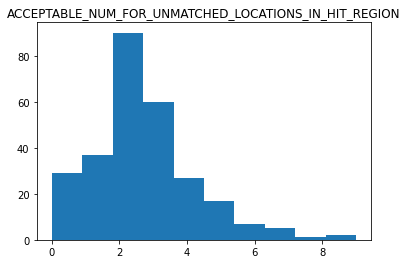

In [69]:
v = result['ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION']
plt.hist(v)
plt.title("ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION")

In [62]:
result.to_csv("./Result/confident_viridi_ct_analizer.csv", index=False)    